# EazyDiner Tech Assignment

### PROBLEM:
EazyDiner is a table reservation platform for consumers looking for dining places.
Will a new customer who signs up with us, make a booking in the first 7 days of signing up? If the **probability is <20% then keep it in a 0 bucket otherwise in a 1 bucket.**

### Data Set:
2 Input data sets - Consumer and Bookings

### Contents:
* Importing Required Modules and Libraries
* Loading the Given Datasets
* Merging the Two Datasets
* Creating the Labels Needed for Training the Model Later
* Data Cleaning and Missing Data Treatment
* Data Selection and Preprocessing for Model
* Applying Various Models
  1. Splitting the data into train and test data
  2. Logistic Regression Classifier Model
  3. Decision Tree Classifier Model
  4. Random Forest Classifier Model
  5. Gradient Boosted Trees Classifier Model
* Selecting The Best Suited Model and Final Output

# Importing Required Modules and Libraries

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
import time as tm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Loading the Given Datasets
We will first read-in the the two given data sets -
 * Sample_BOOKINGS_Dataset_1.xlsx (containing information about restaurant bookings made by customers over a period)
 * Sample_CUSTOMER_Dataset_2.xlsx (containing information about customers who signed up with EazyDiner over the same period)

Then we shall look at some of the features of the datasets and probably later we may **merge** the two datasets to gain more information and target labels.

In [2]:
bookings = pd.read_excel("Sample_BOOKINGS_Dataset_1.xlsx")  # Let us name this dataset as 'bookings'
bookings                                                    # A preview of the dataset we imported

,date,medium,restaurant_name,location,cust_id
0,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon",5015431352112
1,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata",5015431352115
2,2020-09-01,google,Barbeque Nation,"Ambience Mall, Gurgaon",5015431352121
3,2020-09-04,google,Barbeque Pride,"Hitech City, Hyderabad",5015431352122
4,2020-09-06,google,Float Brewery,"Kalyan Nagar, North Bengaluru",5015431352123
...,...,...,...,...,...
61341,2020-12-01,google,Deccan Pavilion,ITC Kakatiya,5015433432040
61342,2020-12-01,google,Barbeque Nation,"Hill Road, Bandra West, Western Suburbs",5015433432043
61343,2020-12-04,web,Barbeque Nation,"MI Road, Jaipur",5015433432044
61344,2020-12-11,web,Lake View Cafe,"Renaissance Mumbai Convention Centre & Hotel, ...",5015433432050


In [3]:
consumer = pd.read_excel("Sample_CUSTOMER_Dataset_2.xlsx")   # Let us name this dataset as 'consumer'
consumer                                                     # A preview of the dataset we imported

,cust_id,name,city,gender,AGE,medium,signup_date
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01
2,5015431352114,mani,Chennai,M,29,android,2020-09-01
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01
4,5015431352120,Bharath,NaN,M,32,google,2020-09-01
...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NaN,18,web,2020-11-30
98350,5015433432051,Kumud Sharma,Delhi NCR,NaN,36,android,2020-11-30
98351,5015433432052,Pramod,Kolhapur,NaN,78,google,2020-11-30
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NaN,28,android,2020-11-30


In [4]:
print ("No of entries in the bookings dataset:", bookings.shape[0])
print ("No of features in the bookings dataset:", bookings.shape[1])

No of entries in the bookings dataset: 61346
No of features in the bookings dataset: 5


In [5]:
print ("List of Features of the bookings dataset:\n", list(bookings.columns))

List of Features of the bookings dataset:
 ['date', 'medium', 'restaurant_name', 'location', 'cust_id']


In [6]:
bookings.isnull().sum()           # Let us check the number of missing entires in the bookings dataset for each feature

date               0
medium             0
restaurant_name    0
location           0
cust_id            0
dtype: int64

In [7]:
print ("No of entries in the consumer dataset:", consumer.shape[0])
print ("No of features in the consumer dataset:", consumer.shape[1])

No of entries in the consumer dataset: 98354
No of features in the consumer dataset: 7


In [8]:
print ("List of Features of the consumer dataset:\n", list(consumer.columns))

List of Features of the consumer dataset:
 ['cust_id', 'name', 'city', 'gender', 'AGE', 'medium', 'signup_date']


In [9]:
consumer.isnull().sum()            # Let us check the number of missing entires in the consumer dataset for each feature

cust_id            0
name            5598
city           17733
gender         93654
AGE                0
medium             0
signup_date        0
dtype: int64

We see there are 5,598 customers who have signed up without providing a name. There are 17,733 customers who have signed up without providing the city they currently are in and there are 93,654 customers out of 98,354 customers who have decided to not provide their gender.

# Merging the Two Datasets
We will now merge both the datasets using left join twice in two different order in order to extract some useful conclusions. We will use the **cust_id** feature to match both the datasets. So, this way we can generate a dataset where we will know which customer made which booking along with the rest of their detail.

But, before merging we notice that both the datasets have a problem. Both datasets have a common column name, i.e., **medium** and it is not necessary that booking_medium and registration medium maybe same.
* So, we rename the *medium* in bookings dataset to *booking_medium*
* Also, so as to remove confussing, we rename *date* in bookings dataset to *booking_date*

In [10]:
bookings.rename(columns={'date':'booking_date', 'medium':'booking_medium'}, inplace=True)
bookings.head()             # Lets confirm our changes

,booking_date,booking_medium,restaurant_name,location,cust_id
0,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon",5015431352112
1,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata",5015431352115
2,2020-09-01,google,Barbeque Nation,"Ambience Mall, Gurgaon",5015431352121
3,2020-09-04,google,Barbeque Pride,"Hitech City, Hyderabad",5015431352122
4,2020-09-06,google,Float Brewery,"Kalyan Nagar, North Bengaluru",5015431352123


#### Now we will merge the consumer and bookings data on cust_id using a left join so as to not lose information on any customer.

In [11]:
data = consumer.merge(bookings, how='left', on='cust_id')       # We name the resulting dataset as 'data'
data

,cust_id,name,city,gender,AGE,medium,signup_date,booking_date,booking_medium,restaurant_name,location
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon"
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,NaT,NaN,NaN,NaN
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,NaT,NaN,NaN,NaN
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata"
4,5015431352120,Bharath,NaN,M,32,google,2020-09-01,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NaN,18,web,2020-11-30,2020-12-11,web,Lake View Cafe,"Renaissance Mumbai Convention Centre & Hotel, ..."
98350,5015433432051,Kumud Sharma,Delhi NCR,NaN,36,android,2020-11-30,NaT,NaN,NaN,NaN
98351,5015433432052,Pramod,Kolhapur,NaN,78,google,2020-11-30,2020-12-02,google,Barbeque Nation,Kolhapur
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NaN,28,android,2020-11-30,NaT,NaN,NaN,NaN


In [12]:
data.dtypes                    # Lets confirm the data types of each field of the DataFrame which will be useful later.

cust_id                     int64
name                       object
city                       object
gender                     object
AGE                         int64
medium                     object
signup_date        datetime64[ns]
booking_date       datetime64[ns]
booking_medium             object
restaurant_name            object
location                   object
dtype: object

In [13]:
data.isnull().sum()                  # Let us check the number of missing entires in the data dataset for each feature

cust_id                0
name                5598
city               17733
gender             93654
AGE                    0
medium                 0
signup_date            0
booking_date       37008
booking_medium     37008
restaurant_name    37008
location           37008
dtype: int64

booking_date, booking_medium, restaurant_name and location have exactly equal no of Null values, i.e., 37,008. From this we can conclude that:
* 3,7008 customers signed up with us but never made a booking in the given time period covered in the bookings dataset, as there is no matching cust_id for them in the bookings dataset.

#### We will now join bookings and consumer datasets on cust_id using a left join 

In [14]:
data2 = bookings.merge(consumer, how = 'left', on = 'cust_id') # Let us name the resulting dataset as 'data2' for now.
data.head()

,cust_id,name,city,gender,AGE,medium,signup_date,booking_date,booking_medium,restaurant_name,location
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon"
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,NaT,NaN,NaN,NaN
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,NaT,NaN,NaN,NaN
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata"
4,5015431352120,Bharath,NaN,M,32,google,2020-09-01,NaT,NaN,NaN,NaN


In [15]:
data2.isnull().sum()            # Let us now check for the null values in data2

booking_date           0
booking_medium         0
restaurant_name        0
location               0
cust_id                0
name                  38
city                   0
gender             58353
AGE                    0
medium                 0
signup_date            0
dtype: int64

We do notice that *38 people* who didnot provide a name have booked with us. So, we are assured that having an entry in the name column is a required criteria for there occuring a booking.<br/>
Also, we notice that there are no missing city values in data2. So, all the *17,733 customers* who didnot provide their city details never made a booking in the given time. So, this also gives us a motive to **not consider the city parameter while making our predictions later** (because this will cause biasness in the model and also it doesnot seem like an important metric for predicting efficiency of booking on a general level)<br/><br/>
Now, we do notice that the number of null values have been decreased. But, **we would not use data2 for futher analysis** because then we will lose data on *37,008 customers out of 98,354 customers*.

# Creating the Labels Needed for Training the Model Later

We will be using the merged dataset "data" for our further analysis. <br/>
Now we we need to create out most important label that will be useful for training our model later. For now we need to see if customer really made a booking with us within 7 days of signing up. If they made a booking then we denote it as 1 and if they didnot we denote it as 0.
* We take the difference of the booking_date and the sign_up date, and store it in a column we name as 'difference'
* Then we check if difference is lesser than or equal to 7 days. Then we denote it as 1 and if greater than 7 days then 0.
* Also, customers who didnot make a booking will be alloted 0.
* We store this in the 'booked' column to be used later for training.

**The "booked' column will be our target variable**

In [16]:
data['difference'] = data['booking_date'] - data['signup_date']
data['booked'] = data['difference'].apply(lambda x : 1 if x<= dt.timedelta(days = 7)  else 0 )
data                               # Let us have a look at our results

,cust_id,name,city,gender,AGE,medium,signup_date,booking_date,booking_medium,restaurant_name,location,difference,booked
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon",3 days,1
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,NaT,NaN,NaN,NaN,NaT,0
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,NaT,NaN,NaN,NaN,NaT,0
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata",5 days,1
4,5015431352120,Bharath,NaN,M,32,google,2020-09-01,NaT,NaN,NaN,NaN,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NaN,18,web,2020-11-30,2020-12-11,web,Lake View Cafe,"Renaissance Mumbai Convention Centre & Hotel, ...",11 days,0
98350,5015433432051,Kumud Sharma,Delhi NCR,NaN,36,android,2020-11-30,NaT,NaN,NaN,NaN,NaT,0
98351,5015433432052,Pramod,Kolhapur,NaN,78,google,2020-11-30,2020-12-02,google,Barbeque Nation,Kolhapur,2 days,1
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NaN,28,android,2020-11-30,NaT,NaN,NaN,NaN,NaT,0


In [17]:
data.drop(columns = ['difference'], inplace = True)    # We no more need the difference column for our further analysis

### Adding the feature of which day of the week it is
It can be seen that by using the Signup date provided we can find out on which day of the week the booking has been done. This will be useful for our further analysis. <br/>
We donot find out the day name for the booking date (because the problems statement wants us to predict based on the signup data)

In [18]:
data['day_of_week'] = data['signup_date'].apply(lambda x: x.strftime('%A'))
data                                              # Lets confirm our changes        

,cust_id,name,city,gender,AGE,medium,signup_date,booking_date,booking_medium,restaurant_name,location,booked,day_of_week
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon",1,Tuesday
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata",1,Tuesday
4,5015431352120,Bharath,NaN,M,32,google,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NaN,18,web,2020-11-30,2020-12-11,web,Lake View Cafe,"Renaissance Mumbai Convention Centre & Hotel, ...",0,Monday
98350,5015433432051,Kumud Sharma,Delhi NCR,NaN,36,android,2020-11-30,NaT,NaN,NaN,NaN,0,Monday
98351,5015433432052,Pramod,Kolhapur,NaN,78,google,2020-11-30,2020-12-02,google,Barbeque Nation,Kolhapur,1,Monday
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NaN,28,android,2020-11-30,NaT,NaN,NaN,NaN,0,Monday


# Data Cleaning and Missing Data Treatment

Our data contains missing data. This will be a barrier when we will proceed for Exploratory Data Analysis. </br>
* We can fill missing gender values with 'NA' as those people might have felt providing gender wasnot important to book a table. 
* Missing name values are filled with 'NotProvided' for now.
* We already have found out that people who didnot provide city details didnot make any booking. So, for lets fill the missing city values with 'NotProvided'


In [19]:
data.fillna(value = {'name':'NotProvided', 'gender':'NA', 'city':'NotProvided',}, inplace = True)
data                                            # Let us check if our changes have been done.

,cust_id,name,city,gender,AGE,medium,signup_date,booking_date,booking_medium,restaurant_name,location,booked,day_of_week
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon",1,Tuesday
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata",1,Tuesday
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NA,18,web,2020-11-30,2020-12-11,web,Lake View Cafe,"Renaissance Mumbai Convention Centre & Hotel, ...",0,Monday
98350,5015433432051,Kumud Sharma,Delhi NCR,NA,36,android,2020-11-30,NaT,NaN,NaN,NaN,0,Monday
98351,5015433432052,Pramod,Kolhapur,NA,78,google,2020-11-30,2020-12-02,google,Barbeque Nation,Kolhapur,1,Monday
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NA,28,android,2020-11-30,NaT,NaN,NaN,NaN,0,Monday


In [20]:
data['gender'].unique()          # Let us see how many categorical values are there in the Gender column

array(['F', 'M', 'Female', 'NA', 'Male'], dtype=object)

It is evident that 'Female' and 'F' are the same gender and 'Male' and 'M' are the same gender.

In [21]:
data['gender']= data['gender'].apply(lambda x: 'F' if x=='Female' else('M' if x=='Male' else x))
data['gender'].unique()               # Let us check if we have only 3 unique categorical values in Gender

array(['F', 'M', 'NA'], dtype=object)

#### Separating the Date of Signup in Day, Month, Year
We can gain more insights into the signup_date by splitting it into day no, month no, and year. This will also make it easier to train the models eventually.

In [22]:
data['signup_day'] = data['signup_date'].apply(lambda x: x.day)
data['signup_month'] = data['signup_date'].apply(lambda x: x.month)
data['signup_year'] = data['signup_date'].apply(lambda x: x.year)
data 

,cust_id,name,city,gender,AGE,medium,signup_date,booking_date,booking_medium,restaurant_name,location,booked,day_of_week,signup_day,signup_month,signup_year
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,2020-09-04,web,Spectra,"The Leela Ambience, Gurgaon",1,Tuesday,1,9,2020
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday,1,9,2020
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday,1,9,2020
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,2020-09-06,google,Barbeque Nation,"Park Street Area, Kolkata",1,Tuesday,1,9,2020
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,NaT,NaN,NaN,NaN,0,Tuesday,1,9,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NA,18,web,2020-11-30,2020-12-11,web,Lake View Cafe,"Renaissance Mumbai Convention Centre & Hotel, ...",0,Monday,30,11,2020
98350,5015433432051,Kumud Sharma,Delhi NCR,NA,36,android,2020-11-30,NaT,NaN,NaN,NaN,0,Monday,30,11,2020
98351,5015433432052,Pramod,Kolhapur,NA,78,google,2020-11-30,2020-12-02,google,Barbeque Nation,Kolhapur,1,Monday,30,11,2020
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NA,28,android,2020-11-30,NaT,NaN,NaN,NaN,0,Monday,30,11,2020


In [23]:
data['signup_year'].unique()       # Let us check how many years does this dataset cover.

array([2020], dtype=int64)

**This dataset contains data of only one year, i.e., 2020**. So, keeping the year field doesnot make sense. We will drop it.

In [24]:
data.drop(columns = 'signup_year', inplace=True)  #The signup_year column is dropped.

### The Problem Statement asks us : Will a new customer who signs up with us, make a booking in the first 7 days of signing up.
So, it is evident that we need to predict based on just signup data provided. So we can only use the data we that we were provided through the consumer dataset and the data we derived from it, along with the target variable that we obtained by merging the datasets. 

In [25]:
data = data[['cust_id','name','city','gender','AGE','medium','signup_date','signup_day','signup_month','day_of_week','booked']]

In [26]:
data.head()            # Let us have a look at what features we are left with

,cust_id,name,city,gender,AGE,medium,signup_date,signup_day,signup_month,day_of_week,booked
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,1,9,Tuesday,1
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,1,9,Tuesday,0
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,1,9,Tuesday,0
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,1,9,Tuesday,1
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,1,9,Tuesday,0


# Exploratory Data Analysis

In [27]:
data.dtypes     # Let us see what are the datatypes of the fields we are left with.

cust_id                  int64
name                    object
city                    object
gender                  object
AGE                      int64
medium                  object
signup_date     datetime64[ns]
signup_day               int64
signup_month             int64
day_of_week             object
booked                   int64
dtype: object

<AxesSubplot:>

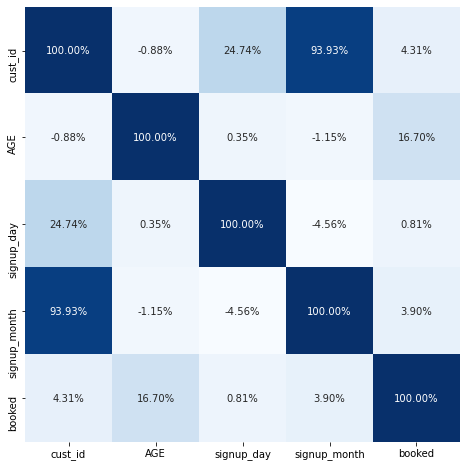

In [28]:
# We will plot a correlation matrix with a heatmap to see if we can get any useful conclusions if any.
plt.figure(figsize = (8,8))
sns.heatmap(data.corr(), cbar=False, square= True, fmt='0.2%', annot=True, cmap='Blues')

In [29]:
data.describe().T               # Getting discriptive stats for numerical columns.

,count,mean,std,min,25%,50%,75%,max
cust_id,98354.0,5.015432e+12,632032.752050,5.015431e+12,5.015432e+12,5.015432e+12,5.015433e+12,5.015433e+12
AGE,98354.0,4.400008e+01,19.809041,1.400000e+01,2.700000e+01,3.900000e+01,6.000000e+01,8.400000e+01
signup_day,98354.0,1.576087e+01,8.802928,1.000000e+00,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
signup_month,98354.0,1.017641e+01,0.777232,9.000000e+00,1.000000e+01,1.000000e+01,1.100000e+01,1.100000e+01
booked,98354.0,5.561543e-01,0.496839,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


array([[<AxesSubplot:title={'center':'AGE'}>]], dtype=object)

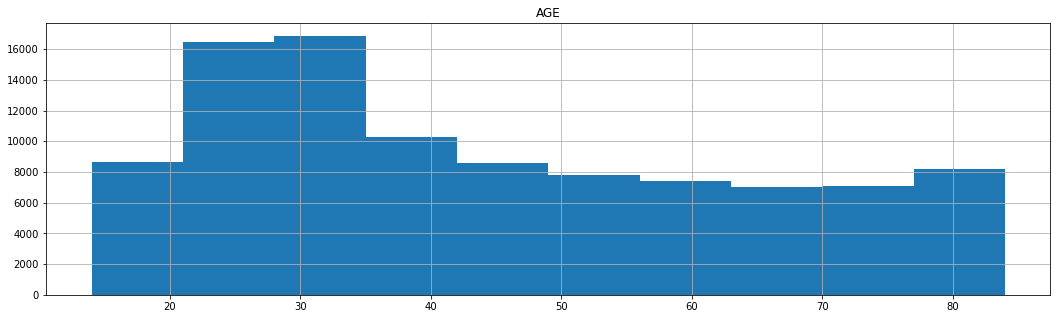

In [30]:
# We want to see if AGE is normally distributed or not. We wil hence get a histogram to see this.
data.hist(['AGE'], figsize=(18,5))

AGE is not Normally distributed with the maximum customers with the age group of 20-40 having most customers. But for a classification problem, this much of skewness is okay.

Now, let us confirm this, by plotting the frequency of AGEs for customers who made a booking in the first 7 days of signup.

array([[<AxesSubplot:title={'center':'AGE'}>]], dtype=object)

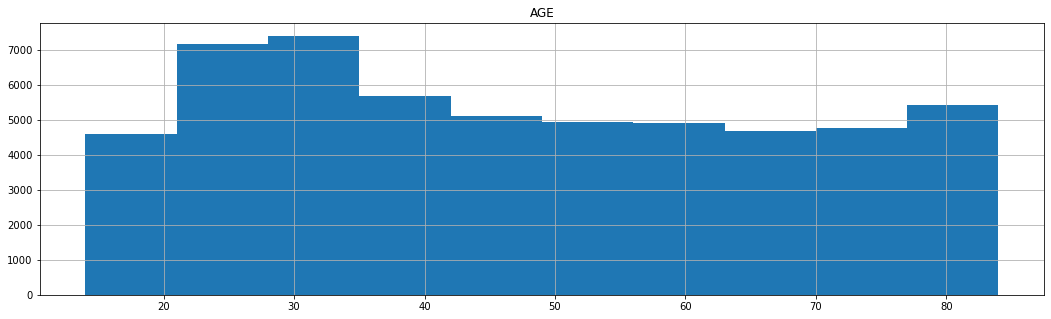

In [31]:
data[data['booked']==1].hist(['AGE'], figsize=(18,5))       #Only considering labels where the customer has booked in 7 days.

We obtain almost a similar structure with the frequency now being more uniformly shared. <br/><br/>
We will now plot bar graphs or count plots for various categorical data.

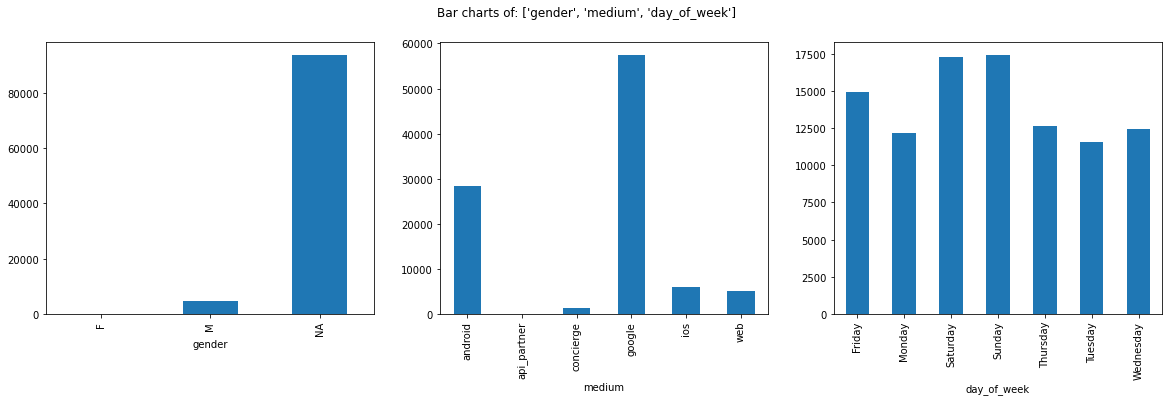

In [32]:
def PlotBarCharts(inpData, colsToPlot):            #function to Plot Bar Graphs of various Categorical Data
    # Generating multiple subplots
    fig, subPlot=plt.subplots(nrows=1, ncols=len(colsToPlot), figsize=(20,5))
    fig.suptitle('Bar charts of: '+ str(colsToPlot))

    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        inpData.groupby(colName).size().plot(kind='bar',ax=subPlot[plotNumber])

# We will plot bar charts to see frequencies of various categories of gender, medium of signup and day_of_week
PlotBarCharts(inpData = data, colsToPlot = ['gender','medium','day_of_week'])

* As we had seen earlier, most people have not provided their gender. Which is 93,654 customers out of 98,354 customers. **So we will not use gender for our predictions**
* Medium does look like a metric that can be used for predictions.
* Most signups happen on Friday, Saturday, and Sunday.

Now let us plot the same categories for successful signups (i.e., booked within first 7 days)

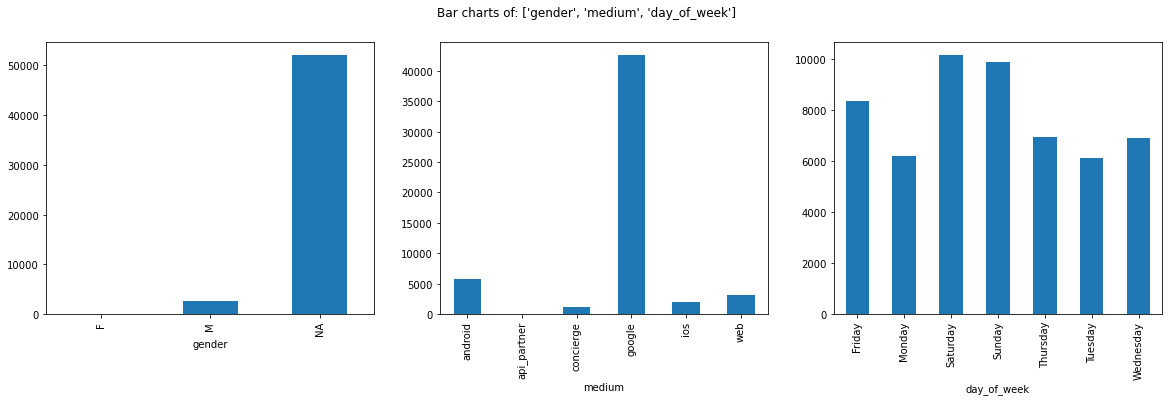

In [33]:
PlotBarCharts(inpData = data[data['booked']==1], colsToPlot = ['gender','medium','day_of_week'])

We see the same pattern has been continued. <br/></br>

Now, we will plot for the categories of signup_day and signup_month 

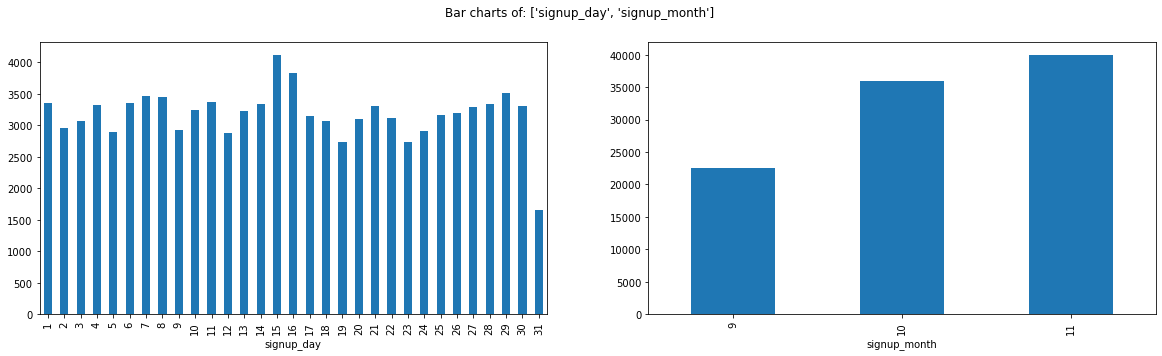

In [34]:
PlotBarCharts(inpData = data, colsToPlot = ['signup_day','signup_month'])

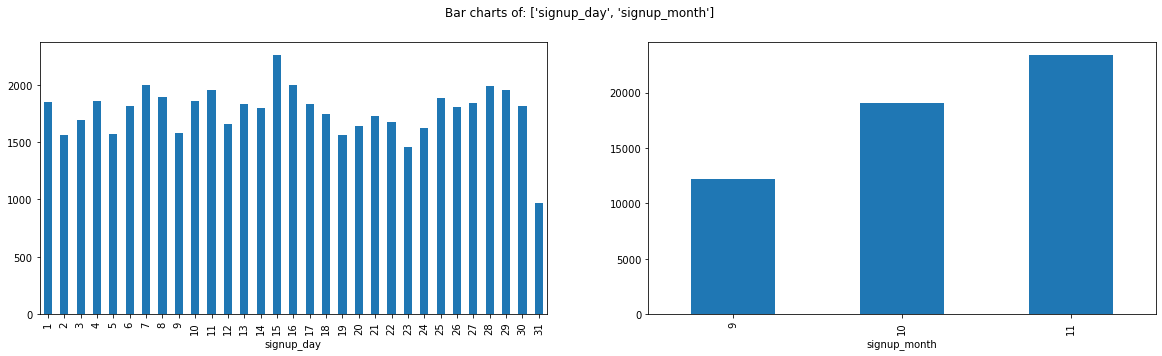

In [35]:
PlotBarCharts(inpData = data[data['booked']==1], colsToPlot = ['signup_day','signup_month'])

# Data Selection and Preprocessing for Model
We now finally select the features we will keep and use for prediction. We will also do some pre-processing on this data before applying our models

In [36]:
DataforML = data[['signup_day','signup_month','day_of_week','medium','AGE','booked']]
DataforML                               #Let us have a look at the features we selected.

,signup_day,signup_month,day_of_week,medium,AGE,booked
0,1,9,Tuesday,web,72,1
1,1,9,Tuesday,android,45,0
2,1,9,Tuesday,android,29,0
3,1,9,Tuesday,google,60,1
4,1,9,Tuesday,google,32,0
...,...,...,...,...,...,...
98349,30,11,Monday,web,18,0
98350,30,11,Monday,android,36,0
98351,30,11,Monday,google,78,1
98352,30,11,Monday,android,28,0


### Label Encoding
day_of_week is a categorical data. So we need to do labelencoding on it to be able to process it through models.

In [37]:
# creating instance of labelencoder for the day_of_week category
encoder_w = LabelEncoder()

encoder_w = encoder_w.fit(DataforML['day_of_week'])  # fitting the encoder on the data 
# Assigning numerical values and storing in another column
DataforML['day_of_week_cat'] = np.array(encoder_w.transform(DataforML['day_of_week']))

<ipython-input-37-5ca9dbb9dd96>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataforML['day_of_week_cat'] = np.array(encoder_w.transform(DataforML['day_of_week']))


medium is a categorical data. So we need to do labelencoding on it to be able to process it through models.

In [38]:
# creating instance of labelencoder for the medium category
encoder_m = LabelEncoder()

encoder_m = encoder_m.fit(DataforML['medium'])   #fitting the encoder on the data
# Assigning numerical values and storing in another column
DataforML['medium_cat'] = np.array(encoder_m.transform(DataforML['medium']))

<ipython-input-38-33529238eaea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataforML['medium_cat'] = np.array(encoder_m.transform(DataforML['medium']))


**The error raised doesnot have any issues.** We can check this by having a look at our dataset and if the required columns have been added or not.

In [39]:
DataforML

,signup_day,signup_month,day_of_week,medium,AGE,booked,day_of_week_cat,medium_cat
0,1,9,Tuesday,web,72,1,5,5
1,1,9,Tuesday,android,45,0,5,0
2,1,9,Tuesday,android,29,0,5,0
3,1,9,Tuesday,google,60,1,5,3
4,1,9,Tuesday,google,32,0,5,3
...,...,...,...,...,...,...,...,...
98349,30,11,Monday,web,18,0,1,5
98350,30,11,Monday,android,36,0,1,0
98351,30,11,Monday,google,78,1,1,3
98352,30,11,Monday,android,28,0,1,0


Finally We can remove the text columns for the categorical data and keep only the encoded versions.

In [40]:
FinalData = DataforML[['signup_day','signup_month','day_of_week_cat','medium_cat','AGE','booked']]
FinalData

,signup_day,signup_month,day_of_week_cat,medium_cat,AGE,booked
0,1,9,5,5,72,1
1,1,9,5,0,45,0
2,1,9,5,0,29,0
3,1,9,5,3,60,1
4,1,9,5,3,32,0
...,...,...,...,...,...,...
98349,30,11,1,5,18,0
98350,30,11,1,0,36,0
98351,30,11,1,3,78,1
98352,30,11,1,0,28,0


# Applying Various Models
We will now apply various models and select the best-fitting model among all.
**We will judge the accuracy of the models on the ability to predict the correct probability of a user signing up in 7 days with the threshold of putting into buckets being 20% or 0.20**

## Splitting the data into train and test data

In [41]:
TargetVariable = 'booked'
Predictors = ['signup_day','signup_month','day_of_week_cat','medium_cat','AGE']

X = DataforML[Predictors].values
y = DataforML[TargetVariable].values

# We will go for a 75%-25% Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42) 

In [42]:
print("Dimensions of X_train:", X_train.shape)
print ("Dimensions of y_train:", y_train.shape)
print ("Dimensions of X_test:", X_test.shape)
print ("Dimensions of y_test:", y_test.shape)

Dimensions of X_train: (73765, 5)
Dimensions of y_train: (73765,)
Dimensions of X_test: (24589, 5)
Dimensions of y_test: (24589,)


### Setting our required Threshold Values
The problems says:<br/>
**If the probability is <20% then keep it in a 0 bucket otherwise in a 1 bucket.**

In [43]:
THRESHOLD = 0.20 #We set our threshold value to 0.20 or 20%

## Logistic Regression Classifier Model

In [44]:
log_reg = LogisticRegression(penalty = 'l2', class_weight = "balanced")
log_reg = log_reg.fit(X_train, y_train)


# predict_proba function gives us the probability of achieving the labels 0 and 1 respectively for each data entry
log_reg.predict_proba(X_test)

array([[0.41729732, 0.58270268],
       [0.32394972, 0.67605028],
       [0.23904505, 0.76095495],
       ...,
       [0.77197434, 0.22802566],
       [0.44191088, 0.55808912],
       [0.47143479, 0.52856521]])

In [45]:
# We need to choose the probability to achieving 1 hence, [:,1] is used
# Also if probability<0.2, then we classify it as 0, and else we classify it as 1
preds = np.where(log_reg.predict_proba(X_test)[:,1] < THRESHOLD, 0, 1)
preds

array([1, 1, 1, ..., 1, 1, 1])

In [46]:
# Let us also calculate the predictions for the training set
preds_train = np.where(log_reg.predict_proba(X_train)[:,1] < THRESHOLD, 0, 1)
preds_train

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
# Outputing the various performance metrics
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds), accuracy_score(y_train, preds_train)], 
             index=["test_accuracy", "recall", "precision", "roc_auc_score","train_accuracy"],
             columns = ['Logistic Regression'])

,Logistic Regression
test_accuracy,0.586522
recall,0.978370
precision,0.573907
roc_auc_score,0.540290
train_accuracy,0.589683


## Decision Tree Classifier Model

In [48]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', random_state=0, max_depth = 4)
decision_tree = decision_tree.fit(X_train, y_train)

In [49]:
# if probability<0.2, then we classify it as 0, and else we classify it as 1
preds = np.where(decision_tree.predict_proba(X_test)[:,1] < THRESHOLD, 0, 1)   # for test set
preds_train = np.where(decision_tree.predict_proba(X_train)[:,1] < THRESHOLD, 0, 1) # for training set 

In [50]:
# Outputing the various performance metrics
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds), accuracy_score(y_train, preds_train)], 
             index=["test_accuracy", "recall", "precision", "roc_auc_score","train_accuracy"],
             columns = ["Decision Tree Classifier"])

,Decision Tree Classifier
test_accuracy,0.632315
recall,0.966083
precision,0.604809
roc_auc_score,0.592935
train_accuracy,0.634529


## Random Forest Classifier Model

In [51]:
rand_for = RandomForestClassifier(n_estimators = 10, criterion = 'entropy') 
rand_for = rand_for.fit(X_train, y_train)
#manual tuning for n_estimators or number of trees was done to ensure overfitting or underfiting doesnot happen.

In [52]:
# if probability<0.2, then we classify it as 0, and else we classify it as 1
preds = np.where(rand_for.predict_proba(X_test)[:,1] < THRESHOLD, 0, 1)
preds_train = np.where(rand_for.predict_proba(X_train)[:,1] < THRESHOLD, 0, 1)

In [53]:
# Outputing the various performance metrics
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds), accuracy_score(y_train, preds_train)], 
             index=["test_accuracy", "recall", "precision", "roc_auc_score","train_accuracy"],
             columns = ["Random Forest Classifier"])

,Random Forest Classifier
test_accuracy,0.658099
recall,0.921204
precision,0.630558
roc_auc_score,0.627056
train_accuracy,0.722090


## Gradient Boosted Trees Classifier Model

In [54]:
grad_tree = GradientBoostingClassifier(n_estimators = 10,  learning_rate=1.0, random_state=0)
grad_tree = grad_tree.fit(X_train, y_train)
#manual tuning for n_estimators or number of trees was done to ensure overfitting or underfiting doesnot happen.

In [55]:
# if probability<0.2, then we classify it as 0, and else we classify it as 1
preds = np.where(grad_tree.predict_proba(X_test)[:,1] < THRESHOLD, 0, 1)
preds_train = np.where(grad_tree.predict_proba(X_train)[:,1] < THRESHOLD, 0, 1)

In [56]:
# Outputing the various performance metrics
pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds), accuracy_score(y_train, preds_train)], 
             index=["test_accuracy", "recall", "precision", "roc_auc_score","train_accuracy"],
             columns = ["Gradient Boosted Trees Classifier"])

,Gradient Boosted Trees Classifier
test_accuracy,0.634023
recall,0.964317
precision,0.606216
roc_auc_score,0.595053
train_accuracy,0.638663


# Selecting The Best Suited Model and Final Output

Now, form the confussion matrix: <br/>
**Recall = TruePositives / (TruePositives + FalseNegatives)** <br/>
**Precision = TruePositives / (TruePositives + FalsePositives)**<br/><br/>
So, Precision is a fraction of how many of the samples we put in the 1 bucket were correct.<br/>
And, Recall is a fraction of how many of correct sample we put in the 1 bucket out of the total of the correct samples we put in the 1 bucket and the wrong ones we put in the 0 bucket. <br/><br/>
So, for our case, we donot want to lose out on customers who could have made a booking with us within the 7 days. **So, *recall* becomes a more important metric** for us than precision.<br/>
This is so because, even if we have a low fraction of customers whom we predicted that would make a booking (or would be in the 1 bucket), it wouldnot hurt our business compared to if we classify someone to be in the 0 bucket whereas they should be in the 1 bucket and not provide them with for.eg, promo codes or discounts or ads at the right time to give them more incentive to do a booking.

So we will be looking at all the metrics to decide the best model with a special consideration for 
* test_accuracy and train_accuracy to get an idea of under-fitting and over-fitting and overall performance
* recall score as it is more important to the business and the problem statement
* precision score (to see if it is not very low)

We can narrow it down between two models:
* Decision Tree Classifier Model
  - test_accuracy : 0.632315
  - train_accuracy : 0.634529
  - recall : 0.966083
  - precision : 0.604809
* Random Forest Classifier Model
  - test_accuracy : 0.655740
  - train_accuracy : 0.722578
  - recall : 0.917819
  - precision : 0.629319

**We choose the Random Forest Classifier Model** as it has a better test and train accuracy and also a better recall values.
Also, with the Model containing only 10 parallel trees, it will also not be computationally difficult.

## Final Output

In [57]:
# We will use the original complete data and use the features required to produce the final output to solve the problem
data.head()

,cust_id,name,city,gender,AGE,medium,signup_date,signup_day,signup_month,day_of_week,booked
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,1,9,Tuesday,1
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,1,9,Tuesday,0
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,1,9,Tuesday,0
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,1,9,Tuesday,1
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,1,9,Tuesday,0


In [58]:
# First we need to labelEncode the categorical variables again. But this time we will not delete the original rows.
data['day_of_week_cat'] = np.array(encoder_w.transform(data['day_of_week']))
data['medium_cat'] = np.array(encoder_m.transform(data['medium']))

<ipython-input-58-c71c9e5e2716>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_week_cat'] = np.array(encoder_w.transform(data['day_of_week']))
<ipython-input-58-c71c9e5e2716>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['medium_cat'] = np.array(encoder_m.transform(data['medium']))


In [59]:
data.head()                    #to confirm the changes

,cust_id,name,city,gender,AGE,medium,signup_date,signup_day,signup_month,day_of_week,booked,day_of_week_cat,medium_cat
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,1,9,Tuesday,1,5,5
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,1,9,Tuesday,0,5,0
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,1,9,Tuesday,0,5,0
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,1,9,Tuesday,1,5,3
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,1,9,Tuesday,0,5,3


**Now we will calculate the probabilities for all the rows and assign them buckets by our Threshold and then add them back to the Dataframe**

In [60]:
TargetVariable = 'booked'
Predictors = ['signup_day','signup_month','day_of_week_cat','medium_cat','AGE']

X_Full = DataforML[Predictors].values
y_Full = DataforML[TargetVariable].values

# We will now find out the probability of a customer making a booking within 7 days of signing up
probabilities = rand_for.predict_proba(X_Full)[:,1]

In [61]:
print("Probabilities:", probabilities)                              # lets check the probabilities array
print ("Shape of array", probabilities.shape)                       # and shape

Probabilities: [1.         0.44119048 0.58611111 ... 1.         0.19579204 0.19579204]
Shape of array (98354,)


In [62]:
THRESHOLD = 0.2                                                      # Declaring THRESHOLD variable again to be 20% or 0.20
# if probability<0.2, then we classify it as 0, and else we classify it as 1
predictions = np.where(probabilities < THRESHOLD, 0, 1)              

In [63]:
print("Predictions:", predictions)                              # lets check the predictions array
print ("Shape of array", predictions.shape)                     # and shape

Predictions: [1 1 1 ... 1 0 0]
Shape of array (98354,)


In [64]:
# Let us check the overall metrics once for the complete data
pd.DataFrame(data=[accuracy_score(y_Full, predictions), recall_score(y_Full, predictions),
                   precision_score(y_Full, predictions)], 
             index=["accuracy", "recall", "precision"], columns = ["Chosen : Random Forest Classifier"])

,Chosen : Random Forest Classifier
accuracy,0.706092
recall,0.963236
precision,0.662047


We have quite a good 0.70 accuracy and 0.96 Recall on the entire Customer dataset. So, the model is able to predict without taking much computational time.

In [65]:
# We will now add back the probabilites and predicted Container Values
data['probability'] = np.round(probabilities,2).reshape(-1,1) # corresponding to booking within 7 days of signup
data['pred_booking'] = predictions.reshape(-1,1)

<ipython-input-65-bf0e7da9fceb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['probability'] = np.round(probabilities,2).reshape(-1,1) # corresponding to booking within 7 days of signup


In [66]:
data.head()                #Let us confirm our additions

,cust_id,name,city,gender,AGE,medium,signup_date,signup_day,signup_month,day_of_week,booked,day_of_week_cat,medium_cat,probability,pred_booking
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,1,9,Tuesday,1,5,5,1.00,1
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,1,9,Tuesday,0,5,0,0.44,1
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,1,9,Tuesday,0,5,0,0.59,1
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,1,9,Tuesday,1,5,3,0.90,1
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,1,9,Tuesday,0,5,3,0.43,1


Now, we will drop our LabelEncoded columns and extra extrated values. To make the dataset look more cleaner so as to just contain the required values for making conclusions out of it.<br/>
We will also reorder the columns and rename the 'booked' columns as 'actual_booking'

In [67]:
data.rename(columns={'booked':'actual_booking'}, inplace = True)
cols_in_order = ['cust_id','name','city','gender','AGE','medium','signup_date','day_of_week','probability','pred_booking'
                 ,'actual_booking']
data = data[cols_in_order]

In [68]:
data.to_pickle('Final_Prediction_Data.csv')    # Storing the final prediction data in a csv file
data.to_pickle('Final_Prediction_Data.xlsx')   # Storing the final prediction data in a xlsx file
data.to_pickle('Final_Prediction_Data.pickle')  # Storing the final prediction data in a pickle file

## Final Prediction Data

In [69]:
data

,cust_id,name,city,gender,AGE,medium,signup_date,day_of_week,probability,pred_booking,actual_booking
0,5015431352112,Juhi Agrawal,Delhi NCR,F,72,web,2020-09-01,Tuesday,1.00,1,1
1,5015431352113,Manish,Delhi NCR,M,45,android,2020-09-01,Tuesday,0.44,1,0
2,5015431352114,mani,Chennai,M,29,android,2020-09-01,Tuesday,0.59,1,0
3,5015431352115,Rija,Kolkata,F,60,google,2020-09-01,Tuesday,0.90,1,1
4,5015431352120,Bharath,NotProvided,M,32,google,2020-09-01,Tuesday,0.43,1,0
...,...,...,...,...,...,...,...,...,...,...,...
98349,5015433432050,Datta,Mumbai,NA,18,web,2020-11-30,Monday,0.10,0,0
98350,5015433432051,Kumud Sharma,Delhi NCR,NA,36,android,2020-11-30,Monday,0.00,0,0
98351,5015433432052,Pramod,Kolhapur,NA,78,google,2020-11-30,Monday,1.00,1,1
98352,5015433432053,Tanzeem Ahmed,Bengaluru,NA,28,android,2020-11-30,Monday,0.20,0,0


In [70]:
# Showing the overall metrics once more on the complete data
pd.DataFrame(data=[accuracy_score(y_Full, predictions), recall_score(y_Full, predictions),
                   precision_score(y_Full, predictions)], 
             index=["accuracy", "recall", "precision"], columns = ["Chosen : Random Forest Classifier"])

,Chosen : Random Forest Classifier
accuracy,0.706092
recall,0.963236
precision,0.662047
